In [14]:
import numpy as np
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"
np.set_printoptions(precision=3, suppress=True)

import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits, fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

import matplotlib.pyplot as plt
% matplotlib inline

from joblib import Memory

mem = Memory(location='/tmp')

# get some data
digits = load_digits()
X, y = digits.data, digits.target
@mem.cache
def bla():
    mnist = fetch_openml("mnist_784")
    return mnist.data, mnist.target

# X, y = bla()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)



# Multifidelity Search
## training size in SVC

In [27]:
from sklearn.svm import SVC
param_grid = {'gamma': np.logspace(-3, 3, 7), 'C': np.logspace(-3, 3, 7)}
param_grid

{'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [50]:
tot_time = []
results = []
train_sizes = [0.1, 0.2, 0.4, 0.8]
for train_size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X / 16., y, stratify=y, random_state=1, train_size=train_size)
    grid_search = GridSearchCV(SVC(), param_grid=param_grid, cv=5, iid=False)
    start = time.time()
    grid_search.fit(X_train, y_train)
    tot_time.append(time.time() - start)
    res = pd.DataFrame(grid_search.cv_results_).pivot(index='param_C', columns='param_gamma', values='mean_test_score')
    results.append(res)

/home/andy/checkout/scikit-learn/sklearn/model_selection/_split.py:2184: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/andy/checkout/scikit-learn/sklearn/model_selection/_split.py:2184: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/andy/checkout/scikit-learn/sklearn/model_selection/_split.py:2184: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/andy/checkout/scikit-learn/sklearn/model_selection/_split.py:2184: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


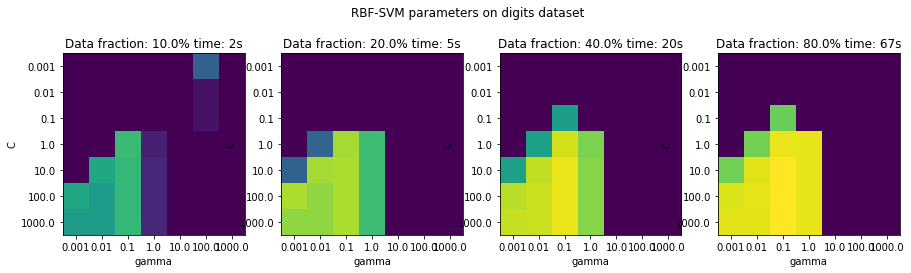

In [96]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
for i, ax in enumerate(axes):
    ax.imshow(results[i].values, vmin=.8, vmax=.99)
    ax.set_title("Data fraction: {}% time: {:.0f}s".format(train_sizes[i] * 100, tot_time[i]))
    ax.set_xticks(np.arange(7))
    ax.set_xticklabels(param_grid['gamma'])
    ax.set_xlabel('gamma')
    ax.set_yticks(np.arange(7))
    ax.set_yticklabels(param_grid['C'])
    ax.set_ylabel('C')
plt.suptitle("RBF-SVM parameters on digits dataset")
plt.savefig("images/multi-fidelity-digits.png")

# n_estimators in Random Forest

In [62]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_features=2).fit(digits.data, digits.target)
tree.get_depth()

19

In [67]:
param_grid_rf = {'max_depth': [1, 2, 4, 8, 12, 16, 19], 'max_features': [2, 4, 8, 16, 32, 64]}
tot_time_rf = []
results_rf = []
n_estimators = [10, 40, 80, 160]
X_train, X_test, y_train, y_test = train_test_split(X / 16., y, stratify=y, random_state=1)

for n_ests in n_estimators:
    grid_search = GridSearchCV(RandomForestClassifier(n_estimators=n_ests), param_grid=param_grid_rf, cv=5, iid=False)
    start = time.time()
    grid_search.fit(X_train, y_train)
    tot_time_rf.append(time.time() - start)
    res = pd.DataFrame(grid_search.cv_results_).pivot(index='param_max_depth', columns='param_max_features', values='mean_test_score')
    results_rf.append(res)

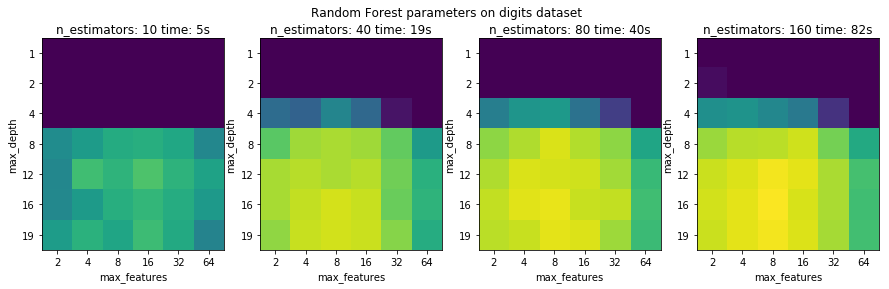

In [100]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

for i, ax in enumerate(axes):
    im = ax.imshow(results_rf[i].values, vmin=.85, vmax=.98)
    ax.set_title("n_estimators: {} time: {:.0f}s".format(n_estimators[i], tot_time_rf[i]))
    ax.set_xticks(np.arange(len(param_grid_rf['max_features'])))
    ax.set_xticklabels(param_grid_rf['max_features'])
    ax.set_xlabel('max_features')
    ax.set_yticks(np.arange(len(param_grid_rf['max_depth'])))
    ax.set_yticklabels(param_grid_rf['max_depth'])
    ax.set_ylabel('max_depth')
#plt.colorbar(im, ax=axes)
plt.suptitle("Random Forest parameters on digits dataset")
plt.savefig("images/multi-fidelity-digits-rf.png")

In [103]:
np.log2(10000)

13.287712379549449

In [104]:
from  civismlext import HyperbandSearchCV

In [297]:
# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}



# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}


In [109]:
hp = HyperbandSearchCV(clf, param_distributions=param_dist, cost_parameter_max={'n_estimators': 200}, cv=5, verbose=10)

In [110]:
hp.fit(X_train, y_train)

Fitting 5 folds for each of 206 candidates, totalling 1030 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s


[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=5, min_samples_split=8, n_estimators=2 
[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=5, min_samples_split=8, n_estimators=2, score=(train=0.575, test=0.542), total=   0.0s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=5, min_samples_split=8, n_estimators=2 
[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=5, min_samples_split=8, n_estimators=2, score=(train=0.565, test=0.533), total=   0.0s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=5, min_samples_split=8, n_estimators=2 
[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=5, min_samples_split=8, n_estimators=2, score=(train=0.596, test=0.546), total=   0.0s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=5, min_samples_split=8, n_estimators=2 
[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=5, min_samples_split=8, n_estimators=2, score=(

[Parallel(n_jobs=1)]: Done 715 out of 715 | elapsed:   24.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s


[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=10, min_samples_split=6, n_estimators=6, score=(train=0.988, test=0.929), total=   0.0s
[CV] bootstrap=True, criterion=entropy, max_depth=None, max_features=10, min_samples_split=6, n_estimators=6 
[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=10, min_samples_split=6, n_estimators=6, score=(train=0.994, test=0.921), total=   0.0s
[CV] bootstrap=True, criterion=entropy, max_depth=None, max_features=10, min_samples_split=6, n_estimators=6 
[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=10, min_samples_split=6, n_estimators=6, score=(train=0.996, test=0.929), total=   0.0s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, n_estimators=6 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, n_estimators=6, score=(train=1.000, test=0.905), total=   0.0s
[CV] bootstrap=False, criterion=entr

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, n_estimators=6, score=(train=1.000, test=0.929), total=   0.0s
[CV] bootstrap=True, criterion=gini, max_depth=None, max_features=6, min_samples_split=7, n_estimators=6 
[CV]  bootstrap=True, criterion=gini, max_depth=None, max_features=6, min_samples_split=7, n_estimators=6, score=(train=0.987, test=0.902), total=   0.0s
[CV] bootstrap=True, criterion=gini, max_depth=None, max_features=6, min_samples_split=7, n_estimators=6 
[CV]  bootstrap=True, criterion=gini, max_depth=None, max_features=6, min_samples_split=7, n_estimators=6, score=(train=0.985, test=0.930), total=   0.0s
[CV] bootstrap=True, criterion=gini, max_depth=None, max_features=6, min_samples_split=7, n_estimators=6 
[CV]  bootstrap=True, criterion=gini, max_depth=None, max_features=6, min_samples_split=7, n_estimators=6, score=(train=0.989, test=0.903), total=   0.0s
[CV] bootstrap=True, criterion=gini, max_depth=None, max_feat

[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   17.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, n_estimators=18, score=(train=1.000, test=0.970), total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, n_estimators=18 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, n_estimators=18, score=(train=1.000, test=0.970), total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, n_estimators=18 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, n_estimators=18, score=(train=1.000, test=0.951), total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, n_estimators=18 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, n_estimators=18, score=(train=1.000, test=0.959), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, n_estimators=18 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, n_estimators=18, score=(train=1.000, test=0.920), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, n_estimators=18 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, n_estimators=18, score=(train=1.000, test=0.967), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, n_estimators=18 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, n_estimators=18, score=(train=1.000, test=0.963), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, n_estimators=18 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, n_estimators=18, score=(train=1.000, test=0.959), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, n_estimators=18 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, n_estimators=18, score=(train=1.000, test=0.936), total=   0.0s
[CV] bootstrap=False, criterion=gini, 

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.0s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3, n_estimators=18, score=(train=1.000, test=0.945), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3, n_estimators=18 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3, n_estimators=18, score=(train=1.000, test=0.978), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3, n_estimators=18 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3, n_estimators=18, score=(train=1.000, test=0.963), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3, n_estimators=18 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3, n_estimators=18, score=(train=1.000, test=0.963), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_dep

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:   11.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=7, n_estimators=54, score=(train=1.000, test=0.964), total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=7, n_estimators=54 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=7, n_estimators=54, score=(train=1.000, test=0.978), total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=7, n_estimators=54 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=7, n_estimators=54, score=(train=1.000, test=0.978), total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=7, n_estimators=54 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=7, n_estimators=54, score=(train=1.000, test=0.974), total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=7, n_estimators=54 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=7, n_estimators=54, score=(train=1.000, test=0.977), total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=7, min_samples_split=4, n_estimators=54 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=7, min_samples_split=4, n_estimators=54, score=(train=1.000, test=0.964), total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=7, min_samples_split=4, n_estimators=54 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.1s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=7, min_samples_split=4, n_estimators=54, score=(train=1.000, test=0.981), total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=7, min_samples_split=4, n_estimators=54 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.4s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=7, min_samples_split=4, n_estimators=54, score=(train=1.000, test=0.978), total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=7, min_samples_split=4, n_estimators=54 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.7s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=7, min_samples_split=4, n_estimators=54, score=(train=1.000, test=0.978), total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=7, min_samples_split=4, n_estimators=54 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.0s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=7, min_samples_split=4, n_estimators=54, score=(train=1.000, test=0.974), total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=6, min_samples_split=7, n_estimators=54 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=6, min_samples_split=7, n_estimators=54, score=(train=1.000, test=0.967), total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=6, min_samples_split=7, n_estimators=54 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=6, min_samples_split=7, n_estimators=54, score=(train=1.000, test=0.981), total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=6, min_samples_split=7, n_estimators=54 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=6, min_samples_split=7, n_estimators=54, score=(train=1.000, test=0.970), total=   0.2s
[CV] bootstrap=False, criterion

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    8.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=7, min_samples_split=4, n_estimators=162, score=(train=1.000, test=0.964), total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=7, min_samples_split=4, n_estimators=162 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=7, min_samples_split=4, n_estimators=162, score=(train=1.000, test=0.981), total=   0.8s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=7, min_samples_split=4, n_estimators=162 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=7, min_samples_split=4, n_estimators=162, score=(train=1.000, test=0.985), total=   1.0s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=7, min_samples_split=4, n_estimators=162 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=7, min_samples_split=4, n_estimators=162, score=(train=1.000, test=0.985), total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=7, min_samples_split=4, n_estimators=162 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.4s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=7, min_samples_split=4, n_estimators=162, score=(train=1.000, test=0.977), total=   0.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.0s finished


HyperbandSearchCV(cost_parameter_max={'n_estimators': 200},
                  cost_parameter_min=None, cv=5, error_score='raise',
                  estimator=RandomForestClassifier(bootstrap=True,
                                                   class_weight=None,
                                                   criterion='gini',
              ...': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2b00eea828>,
                                       'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2b00eea940>},
                  pre_dispatch='2*n_jobs', random_state=None, refit=True,
                  return_train_score=True, scoring=None, verbose=10)

In [299]:
from halving import GridSuccessiveHalving
sh = GridSuccessiveHalving(clf, param_grid=param_grid, cv=5, random_state=0)
start = time.time()
sh.fit(X_train, y_train)

print("Successive Halving took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(sh.cv_results_['params'])))
report(sh.cv_results_)

7
n_samples_iter: 100
n_samples_iter: 100


/home/andy/checkout/scikit-learn/sklearn/model_selection/_split.py:643: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


n_samples_iter: 100


/home/andy/checkout/scikit-learn/sklearn/model_selection/_split.py:643: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


n_samples_iter: 100
n_samples_iter: 100
n_samples_iter: 100
n_samples_iter: 100
Successive Halving took 12.32 seconds for 145 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.885 (std: 0.035)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.875 (std: 0.064)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 3}

Model with rank: 3
Mean validation score: 0.866 (std: 0.072)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'min_samples_split': 3}



In [23]:
sh.score(X_test, y_test)

0.9594285714285714

In [24]:
# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, verbose=10, random_state=0)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] bootstrap=True, criterion=entropy, max_depth=None, max_features=1, min_samples_split=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=1, min_samples_split=5, score=0.936, total=   2.1s
[CV] bootstrap=True, criterion=entropy, max_depth=None, max_features=1, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=1, min_samples_split=5, score=0.934, total=   1.9s
[CV] bootstrap=True, criterion=entropy, max_depth=None, max_features=1, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=1, min_samples_split=5, score=0.928, total=   1.7s
[CV] bootstrap=True, criterion=entropy, max_depth=None, max_features=1, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s


[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=1, min_samples_split=5, score=0.933, total=   1.7s
[CV] bootstrap=True, criterion=entropy, max_depth=None, max_features=1, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.5s remaining:    0.0s


[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=1, min_samples_split=5, score=0.931, total=   1.9s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.4s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, score=0.958, total=   6.0s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   15.4s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, score=0.956, total=   6.1s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.5s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, score=0.955, total=   6.0s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   27.6s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, score=0.956, total=   6.4s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   34.0s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, score=0.954, total=   6.0s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=8, min_samples_split=8 
[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=8, min_samples_split=8, score=0.704, total=   1.2s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=8, min_samples_split=8 
[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=8, min_samples_split=8, score=0.710, total=   1.4s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=8, min_samples_split=8 
[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=8, min_samples_split=8, score=0.730, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=8, min_samples_split=8 
[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=8, min_samples_split=8, score=0.690, total=   1.2s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_featur

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.0min finished


RandomizedSearchCV took 249.71 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.957 (std: 0.003)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 5}

Model with rank: 2
Mean validation score: 0.956 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 9, 'min_samples_split': 6}

Model with rank: 3
Mean validation score: 0.956 (std: 0.001)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 5}



In [32]:
import pandas as pd
#.groupby("params").plot(x="iter", y="mean_test_score")

In [25]:
random_search.score(X_test, y_test)

0.9583428571428572

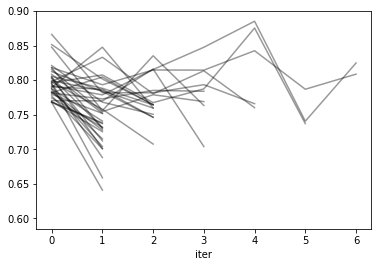

In [300]:
res = pd.DataFrame(sh.cv_results_)
res['params_str'] = res.params.apply(str)
reshape = res.pivot(index='iter', columns='params_str', values='mean_test_score')
reshape.plot(legend=False, alpha=.4, c='k')

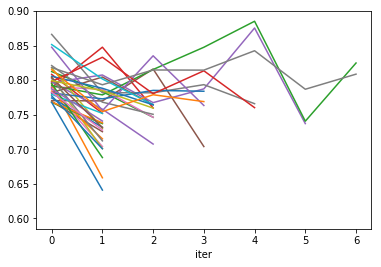

In [301]:
import matplotlib.pyplot as plt
res.groupby("params_str").plot('iter', 'mean_test_score', ax=plt.gca(), legend=False);
plt.savefig("images/halving_curve.png")

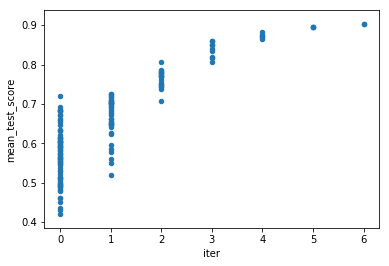

In [38]:
%matplotlib inline
res.plot('iter', 'mean_test_score', kind='scatter')

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X / 255., y, stratify=y, random_state=0, train_size=1000)


/home/andy/checkout/scikit-learn/sklearn/model_selection/_split.py:2184: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [3]:
from sklearn.svm import SVC
param_grid = {'gamma': np.logspace(-3, 2, 6), 'C': np.logspace(-3, 2, 6)}
param_grid

{'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])}

In [70]:
# run grid search
grid_search = GridSearchCV(SVC(), param_grid=param_grid, cv=5, iid=False, verbose=10)
start = time.time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ C=0.001, gamma=0.001, score=0.113, total=   1.4s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ................ C=0.001, gamma=0.001, score=0.113, total=   1.5s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV] ................ C=0.001, gamma=0.001, score=0.114, total=   1.5s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.4s remaining:    0.0s


[CV] ................ C=0.001, gamma=0.001, score=0.111, total=   1.4s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.8s remaining:    0.0s


[CV] ................ C=0.001, gamma=0.001, score=0.113, total=   1.5s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.3s remaining:    0.0s


[CV] ................. C=0.001, gamma=0.01, score=0.113, total=   1.3s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    8.7s remaining:    0.0s


[CV] ................. C=0.001, gamma=0.01, score=0.113, total=   1.4s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   10.0s remaining:    0.0s


[CV] ................. C=0.001, gamma=0.01, score=0.114, total=   1.5s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   11.5s remaining:    0.0s


[CV] ................. C=0.001, gamma=0.01, score=0.111, total=   1.4s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   12.9s remaining:    0.0s


[CV] ................. C=0.001, gamma=0.01, score=0.113, total=   1.6s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] .................. C=0.001, gamma=0.1, score=0.113, total=   1.6s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] .................. C=0.001, gamma=0.1, score=0.113, total=   1.5s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] .................. C=0.001, gamma=0.1, score=0.114, total=   1.6s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] .................. C=0.001, gamma=0.1, score=0.111, total=   1.4s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] .................. C=0.001, gamma=0.1, score=0.113, total=   1.6s
[CV] C=0.001, gamma=1.0 ..............................................
[CV] .................. C=0.001, gamma=1.0, score=0.113, total=   1.5s
[CV] C=0.001, gamma=1.0 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  4.1min finished


GridSearchCV took 244.53 seconds for 36 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.913 (std: 0.015)
Parameters: {'C': 10.0, 'gamma': 0.01}

Model with rank: 1
Mean validation score: 0.913 (std: 0.015)
Parameters: {'C': 100.0, 'gamma': 0.01}

Model with rank: 3
Mean validation score: 0.888 (std: 0.017)
Parameters: {'C': 1.0, 'gamma': 0.01}



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X / 255., y, stratify=y, random_state=0)

sh = GridSuccessiveHalving(SVC(), param_grid=param_grid, cv=5, random_state=0, verbose=10)
start = time.time()
sh.fit(X_train, y_train)

print("Successive Halving took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(sh.cv_results_['params'])))
report(sh.cv_results_)

6
n_samples_iter: 1458
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.001, gamma=0.001, score=(train=0.124, test=0.125), total=   3.1s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV]  C=0.001, gamma=0.001, score=(train=0.124, test=0.123), total=   2.7s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.6s remaining:    0.0s


[CV]  C=0.001, gamma=0.001, score=(train=0.124, test=0.123), total=   2.8s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.9s remaining:    0.0s


[CV]  C=0.001, gamma=0.001, score=(train=0.124, test=0.124), total=   2.8s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.1s remaining:    0.0s


[CV]  C=0.001, gamma=0.001, score=(train=0.124, test=0.125), total=   2.8s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.4s remaining:    0.0s


[CV]  C=0.001, gamma=0.01, score=(train=0.124, test=0.125), total=   2.8s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   25.6s remaining:    0.0s


[CV]  C=0.001, gamma=0.01, score=(train=0.124, test=0.123), total=   2.7s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   29.7s remaining:    0.0s


[CV]  C=0.001, gamma=0.01, score=(train=0.124, test=0.123), total=   2.8s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   33.9s remaining:    0.0s


[CV]  C=0.001, gamma=0.01, score=(train=0.124, test=0.124), total=   2.8s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   38.1s remaining:    0.0s


[CV]  C=0.001, gamma=0.01, score=(train=0.124, test=0.125), total=   2.8s
[CV] C=0.001, gamma=0.1 ..............................................
[CV]  C=0.001, gamma=0.1, score=(train=0.124, test=0.125), total=   2.7s
[CV] C=0.001, gamma=0.1 ..............................................
[CV]  C=0.001, gamma=0.1, score=(train=0.124, test=0.123), total=   2.7s
[CV] C=0.001, gamma=0.1 ..............................................
[CV]  C=0.001, gamma=0.1, score=(train=0.124, test=0.123), total=   2.7s
[CV] C=0.001, gamma=0.1 ..............................................
[CV]  C=0.001, gamma=0.1, score=(train=0.124, test=0.124), total=   2.8s
[CV] C=0.001, gamma=0.1 ..............................................
[CV]  C=0.001, gamma=0.1, score=(train=0.124, test=0.125), total=   2.8s
[CV] C=0.001, gamma=1.0 ..............................................
[CV]  C=0.001, gamma=1.0, score=(train=0.124, test=0.125), total=   2.9s
[CV] C=0.001, gamma=1.0 ......................................

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 996.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=100.0, gamma=0.01, score=(train=1.000, test=0.952), total=   3.3s
[CV] C=100.0, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV]  C=100.0, gamma=0.01, score=(train=1.000, test=0.954), total=   3.4s
[CV] C=100.0, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.0s remaining:    0.0s


[CV]  C=100.0, gamma=0.01, score=(train=1.000, test=0.940), total=   3.3s
[CV] C=100.0, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.4s remaining:    0.0s


[CV]  C=100.0, gamma=0.01, score=(train=1.000, test=0.928), total=   3.4s
[CV] C=100.0, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   26.2s remaining:    0.0s


[CV]  C=100.0, gamma=0.01, score=(train=1.000, test=0.926), total=   3.5s
[CV] C=10.0, gamma=0.01 ..............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.0s remaining:    0.0s


[CV]  C=10.0, gamma=0.01, score=(train=1.000, test=0.952), total=   3.8s
[CV] C=10.0, gamma=0.01 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   41.8s remaining:    0.0s


[CV]  C=10.0, gamma=0.01, score=(train=1.000, test=0.954), total=   5.7s
[CV] C=10.0, gamma=0.01 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   52.5s remaining:    0.0s


[CV]  C=10.0, gamma=0.01, score=(train=1.000, test=0.940), total=   5.5s
[CV] C=10.0, gamma=0.01 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.0min remaining:    0.0s


[CV]  C=10.0, gamma=0.01, score=(train=1.000, test=0.928), total=   6.7s
[CV] C=10.0, gamma=0.01 ..............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.3min remaining:    0.0s


[CV]  C=10.0, gamma=0.01, score=(train=1.000, test=0.926), total=   6.4s
[CV] C=1.0, gamma=0.01 ...............................................
[CV]  C=1.0, gamma=0.01, score=(train=0.972, test=0.940), total=   6.8s
[CV] C=1.0, gamma=0.01 ...............................................
[CV]  C=1.0, gamma=0.01, score=(train=0.970, test=0.933), total=   8.0s
[CV] C=1.0, gamma=0.01 ...............................................
[CV]  C=1.0, gamma=0.01, score=(train=0.973, test=0.937), total=   8.6s
[CV] C=1.0, gamma=0.01 ...............................................
[CV]  C=1.0, gamma=0.01, score=(train=0.969, test=0.929), total=   7.5s
[CV] C=1.0, gamma=0.01 ...............................................
[CV]  C=1.0, gamma=0.01, score=(train=0.971, test=0.903), total=   7.9s
[CV] C=10.0, gamma=0.001 .............................................
[CV]  C=10.0, gamma=0.001, score=(train=0.954, test=0.920), total=   8.0s
[CV] C=10.0, gamma=0.001 ..........................................

In [75]:
grid_search.score(X_test, y_test)


0.9194666666666667

In [10]:
sh.score(X_test, y_test)

0.9187536231884058

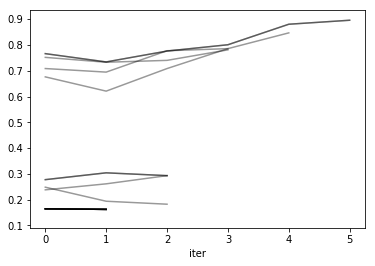

In [5]:
%matplotlib inline
import pandas as pd

res = pd.DataFrame(sh.cv_results_)
res['params_str'] = res.params.apply(str)
reshape = res.pivot(index='iter', columns='params_str', values='mean_test_score')
reshape.plot(legend=False, alpha=.4, c='k')

In [6]:
reshape

params_str,"{'C': 0.001, 'gamma': 0.001}","{'C': 0.001, 'gamma': 0.01}","{'C': 0.001, 'gamma': 0.1}","{'C': 0.001, 'gamma': 1.0}","{'C': 0.001, 'gamma': 10.0}","{'C': 0.001, 'gamma': 100.0}","{'C': 0.01, 'gamma': 0.001}","{'C': 0.01, 'gamma': 0.01}","{'C': 0.01, 'gamma': 0.1}","{'C': 0.01, 'gamma': 1.0}",...,"{'C': 10.0, 'gamma': 0.1}","{'C': 10.0, 'gamma': 1.0}","{'C': 10.0, 'gamma': 10.0}","{'C': 10.0, 'gamma': 100.0}","{'C': 100.0, 'gamma': 0.001}","{'C': 100.0, 'gamma': 0.01}","{'C': 100.0, 'gamma': 0.1}","{'C': 100.0, 'gamma': 1.0}","{'C': 100.0, 'gamma': 10.0}","{'C': 100.0, 'gamma': 100.0}"
iter,,,,,,,,,,,,,,,,,,,,,
0,0.164668,0.164668,0.129374,0.129374,0.164668,0.141138,0.164668,0.164668,0.129374,0.129374,...,0.277687,0.129374,0.164668,0.141138,0.751719,0.766145,0.277687,0.129374,0.164668,0.141138
1,0.162487,NaN,NaN,NaN,NaN,NaN,0.162487,0.162487,NaN,NaN,...,0.304140,NaN,0.162487,NaN,0.732745,0.733937,0.304140,NaN,0.162487,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.293254,NaN,NaN,NaN,0.740079,0.776190,0.293254,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.780840,0.800602,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.880104,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.895587,NaN,NaN,NaN,NaN


In [7]:
bla = res.groupby('params_str')['mean_test_score'].median()

In [8]:
new = res.drop_duplicates(subset='params_str', keep='last')[['param_gamma', 'param_C', 'mean_test_score']]

In [9]:
new.pivot(index='param_C', columns='param_gamma')

mean_test_score                                                  
param_gamma         0.001     0.010     0.100     1.000     10.000    100.000
param_C                                                                      
0.001              0.162487  0.164668  0.129374  0.129374  0.164668  0.141138
0.010              0.162487  0.162487  0.129374  0.129374  0.162487  0.141138
0.100              0.162487  0.164668  0.129374  0.129374  0.162487  0.141138
1.000              0.182540  0.846617  0.293254  0.129374  0.162487  0.141138
10.000             0.785551  0.895587  0.293254  0.129374  0.162487  0.141138
100.000            0.780840  0.895587  0.293254  0.129374  0.162487  0.141138

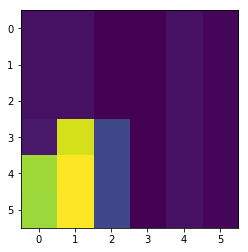

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(new.pivot(index='param_C', columns='param_gamma'))

In [10]:
res.drop_duplicates(subset='params_str', keep='last')[['param_gamma', 'param_C', 'iter']].pivot(index='param_C', columns='param_gamma')

iter                                        
param_gamma 0.001   0.010   0.100   1.000   10.000  100.000
param_C                                                    
0.001             1       0       0       0       0       0
0.010             1       1       0       0       1       0
0.100             1       0       0       0       1       0
1.000             2       4       2       0       1       0
10.000            3       5       2       0       1       0
100.000           3       5       2       0       1       0

In [3]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [5]:
start = time.time()
LogisticRegressionCV(cv=5, multi_class='multinomial', solver='sag').fit(X_train, y_train)
print(time.time() - start)

/home/andy/checkout/scikit-learn/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


KeyboardInterrupt: 

In [226]:
np.logspace(-3, 2, 6)

array([  0.001,   0.01 ,   0.1  ,   1.   ,  10.   , 100.   ])

In [284]:
27 * 3

81

In [290]:
n_params = 81
n_samples = 10000
eta = 3.
budget = 23000

In [291]:
l = np.arange(15)

In [292]:
s = np.where(np.floor(n_params * n_samples * (l + 1) * eta ** -l) < budget)[0].min()
s

5

In [293]:
s = 5

In [294]:
resources_spent = 0
for k in range(0, s + 1):
    n_params_left = np.floor(n_params*eta ** -k)
    if n_params_left < 1:
        break
    resources =  np.floor(n_samples * eta ** (k - s))
    resources_spent += n_params_left * resources
    print("train {} configurations with resources {}".format(int(n_params_left), int(resources)))
print("resources total: {}".format(resources_spent))

train 81 configurations with resources 41
train 27 configurations with resources 123
train 9 configurations with resources 370
train 3 configurations with resources 1111
train 1 configurations with resources 3333
resources total: 16638.0


In [246]:
k

5

In [139]:
n_params

16